In [15]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict

from matplotlib.ticker import PercentFormatter


def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))
    
    
gt_data = pd.read_csv("../results/tables/all.gt_dist.table.txt", sep='\t')
inter_data = pd.read_csv("../results/tables/all.intersect.table.txt", sep='\t')
neigh_data = pd.read_csv("../results/tables/all.neighbor.table.txt", sep='\t')
svtype_data = pd.read_csv("../results/tables/all.svtype.table.txt", sep='\t')

tr_gt_data = pd.read_csv("../results/tables/tr.gt_dist.table.txt", sep='\t')
tr_inter_data = pd.read_csv("../results/tables/tr.intersect.table.txt", sep='\t')
tr_neigh_data = pd.read_csv("../results/tables/tr.neighbor.table.txt", sep='\t')
tr_svtype_data = pd.read_csv("../results/tables/tr.svtype.table.txt", sep='\t')

ntr_gt_data = pd.read_csv("../results/tables/non_tr.gt_dist.table.txt", sep='\t')
ntr_inter_data = pd.read_csv("../results/tables/non_tr.intersect.table.txt", sep='\t')
ntr_neigh_data = pd.read_csv("../results/tables/non_tr.neighbor.table.txt", sep='\t')
ntr_svtype_data = pd.read_csv("../results/tables/non_tr.svtype.table.txt", sep='\t')

On average, kanpig’s average genotype concordance on the 32x coverage experiments was 85.0% compared to 76.2% for svjedi, and 78.1% for cuteSV. Since sniffles was used to discover the SVs, we measured both its original discovery genotypes as well as its force-genotyping modes’ concordance separately at 80.5% and 80.4%, respectively.

In [8]:
view = inter_data[(inter_data['experiment'] == 'ds') &
                 (inter_data['coverage'] == '32x')]

view.groupby(['program'])[['gt_concordance']].mean()


,gt_concordance
program,
cutesv,0.781145
kanpig,0.850740
orig,0.805352
sniffles,0.804316
svjedi,0.763243


 (full strat sup table?)

In [10]:
# Full stratification sup table
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

a = svtype_data[(svtype_data['experiment'] == 'ds')].copy()
a['TR'] = 'all'

b = tr_svtype_data[(tr_svtype_data['experiment'] == 'ds')].copy()
b['TR'] = 'within'

c = ntr_svtype_data[(ntr_svtype_data['experiment'] == 'ds')].copy()
c['TR'] = 'outside'

view = pd.concat([a, b, c])
sup_table = (view.groupby(['program', 'coverage', 'svtype', 'TR'])['GT Concordance'].describe()[['mean', 'std']].reset_index())
program_order = ['kanpig', 'svjedi', 'sniffles', 'cutesv']
coverage_order = ['32x', '16x', '8x']
svtype_order = ['TOT', 'DEL', 'INS']
TR_order = ['all', 'outside', 'within']

sup_table['program'] = pd.Categorical(sup_table['program'], categories=program_order, ordered=True)
sup_table['coverage'] = pd.Categorical(sup_table['coverage'], categories=coverage_order, ordered=True)
sup_table['svtype'] = pd.Categorical(sup_table['svtype'], categories=svtype_order, ordered=True)
sup_table['TR'] = pd.Categorical(sup_table['TR'], categories=TR_order, ordered=True)
sup_table.sort_values(by=['program', 'coverage', 'svtype', 'TR'], inplace=True)

sup_table.to_csv("SupTable_DS_GTconcordance.txt", sep='\t', index=False)

 Unsurprisingly, sniffles force-genotyping on the sniffles discovery SVs created the least amount of change with only 23 FPs and 87 TPs genotyped as reference homozygous per-sample. Kanpig removed an average of 52 FP variants and 206 TPs whereas cutesv removed an average of 51 FP variants and 745 TP variants. Interestingly, while svjedi only lost an average of 50 TP variants per-sample, it also found an average of 63 additional FP variants per-sample.

In [30]:
view = inter_data[(inter_data['experiment'] == 'ds')
                  & ((inter_data['program'] != "orig") | (inter_data['coverage'] == '32x'))
                 ]
view2 = view.groupby(['program', 'coverage'])[['gt_concordance', 'TP-base', 'TP-comp', 'FN', 'FP', 'precision', 'recall', 'f1']].mean()
o = view2.loc[('orig', '32x')]
t = view2.reset_index()
g = t[t['coverage'] == '32x'].set_index(['program', 'coverage'])
diff = g - o
diff

,,gt_concordance,TP-base,TP-comp,FN,FP,precision,recall,f1
program,coverage,,,,,,,,
cutesv,32x,-0.024206,-723.914894,-745.808511,631.489362,-50.872340,0.001536,-0.028023,-0.013964
kanpig,32x,0.045388,-760.297872,-205.638298,914.765957,-51.957447,0.002317,-0.039303,-0.019597
orig,32x,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sniffles,32x,-0.001036,-79.255319,-87.340426,516.361702,-23.042553,0.001025,-0.021185,-0.010550
svjedi,32x,-0.042109,18.446809,-50.340426,27.936170,63.404255,-0.003225,-0.001134,-0.002149


In [31]:
view2.reset_index(inplace=True)
program_order = ['orig', 'kanpig', 'svjedi', 'sniffles', 'cutesv']
coverage_order = ['32x', '16x', '8x']
svtype_order = ['TOT', 'DEL', 'INS']
TR_order = ['all', 'outside', 'within']

view2['program'] = pd.Categorical(view2['program'], categories=program_order, ordered=True)
view2['coverage'] = pd.Categorical(view2['coverage'], categories=coverage_order, ordered=True)
view2.sort_values(by=['program', 'coverage'], inplace=True)
view2.to_csv("SupTable_DS_PrecisionRecall.txt", sep='\t', index=False)

# Sup: DS Overview

In [18]:

YLIM = (0.5, 1.0)
def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))
    
def plot_gtconcordance_barplot(subset, ax, title="Genotype Concordance"):
    p = sb.barplot(data=subset, x="program", y="GT Concordance", hue="coverage", 
                   hue_order=['32x', '16x', '8x'], ax=ax, zorder=2)
    p.set(title=title, ylabel="Overall GT Concordance")
    p.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    categories = subset['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YLIM)
    ax.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='Coverage', loc='upper right')
    legend.get_frame().set_edgecolor('white')
    
def plot_typestrat(subset_a, subset_b, ax1, ax2):
    """
    A is TRs, B is Non-TRs
    """
    p = sb.barplot(data=subset_a, x="program", y="GT Concordance", hue="svtype", 
                   hue_order=['DEL', 'INS'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax1)
    p.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

    categories = subset_a['program'].unique()
    num_categories = len(categories) - 1

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YLIM)
    ax1.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='SV Type', ncol=1, loc='upper right')
    legend.get_frame().set_edgecolor('white')
    ax1.set(ylabel="SVTYPE GT Concordance")

    ## Second half
    p = sb.barplot(data=subset_b, x="program", y="GT Concordance", hue="TR", 
                   hue_order=['inside', 'outside'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax2)
    p.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

    p.set(xlabel="Program", ylabel="TR GT Concordance")

    categories = subset_a['program'].unique()
    num_categories = len(categories) - 1

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YLIM)
    ax2.grid(axis='y', zorder=1)
    #legend = p.legend(frameon=True, title='SV Type', loc='upper right')
    #legend.get_frame().set_edgecolor('white')
    


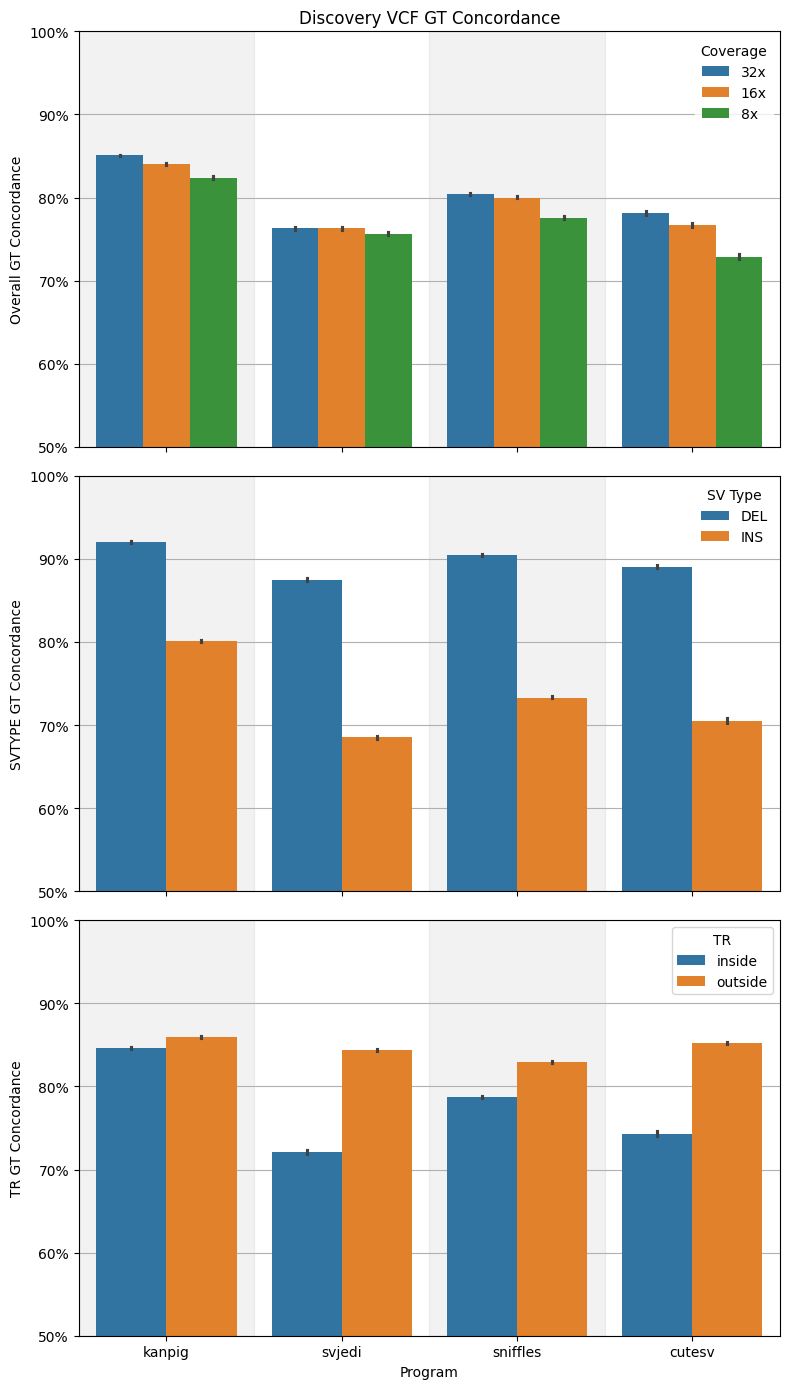

<Figure size 640x480 with 0 Axes>

In [32]:
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

exp = 'ds'

view = svtype_data[(svtype_data['svtype'] == 'TOT')
                    & (svtype_data['experiment'] == exp)
                    & (svtype_data['technology'] == 'pac')]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

plot_gtconcordance_barplot(view, ax1, "Discovery VCF GT Concordance")

a = svtype_data[(tr_svtype_data['svtype'] != 'TOT')
                   & (svtype_data['experiment'] == exp)
                   & (svtype_data['technology'] == 'pac')
                   & (svtype_data['coverage'] == '32x')]

b = tr_svtype_data[(tr_svtype_data['svtype'] == 'TOT')
                   & (tr_svtype_data['experiment'] == exp)
                   & (tr_svtype_data['technology'] == 'pac')
                   & (tr_svtype_data['coverage'] == '32x')].copy()
b['TR'] = 'inside'
c = ntr_svtype_data[(ntr_svtype_data['svtype'] == 'TOT')
                   & (ntr_svtype_data['experiment'] == exp)
                   & (ntr_svtype_data['technology'] == 'pac')
                   & (ntr_svtype_data['coverage'] == '32x')].copy()
c['TR'] = 'outside'
d = pd.concat([b, c]).reset_index(drop=True)

plot_typestrat(a, d, ax2, ax3)
fig.tight_layout()
plt.show()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("SupFigure_DS_Concordance.pdf", format='pdf', bbox_inches='tight')